In [1]:
# 本文件用于测试模型指标，模型训练文件为DeepCFD.py，需要在终端使用python DeepCFD.py运行
import pickle
import json
import paddle
from tool.train_functions import *
from tool.functions import *
from tool.UNetEx import UNetEx

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [2]:
# 保存的模型路径
path = r"./Result/DeepCFD_965.pdparams"
kernel_size = 5
filters = [8, 16, 32, 32]
bn = False
wn = False
net = UNetEx(3, 3, filters=filters, kernel_size=kernel_size, batch_norm=bn, weight_norm=wn)
# 加载模型参数
net.set_state_dict(paddle.load(path))

# 实际运行时需要修改数据路径，数据下载地址：https://www.dropbox.com/s/kg0uxjnbhv390jv/Data_DeepCFD.7z?dl=0
x = pickle.load(open("/home/aistudio/data/data162674/dataX.pkl", "rb"))
y = pickle.load(open("/home/aistudio/data/data162674/dataY.pkl", "rb"))
x = paddle.to_tensor(x, dtype="float32")
y = paddle.to_tensor(y, dtype="float32")
y_trans = paddle.transpose(y, perm=[0, 2, 3, 1])
channels_weights = paddle.reshape(
    paddle.sqrt(paddle.mean(paddle.transpose(y, perm=[0, 2, 3, 1]).reshape((981 * 172 * 79, 3)) ** 2, axis=0)),
    shape=[1, -1, 1, 1])

train_data, test_data = split_tensors(x, y, ratio=0.7)
train_dataset, test_dataset = paddle.io.TensorDataset([train_data[0], train_data[1]]), paddle.io.TensorDataset([test_data[0], test_data[1]])
# 读取测试集
test_x, test_y = test_dataset[:]

W0803 10:36:22.254525 27851 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0803 10:36:22.259187 27851 gpu_resources.cc:91] device: 0, cuDNN Version: 7.6.


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:101: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  ret = np.asscalar(ex)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


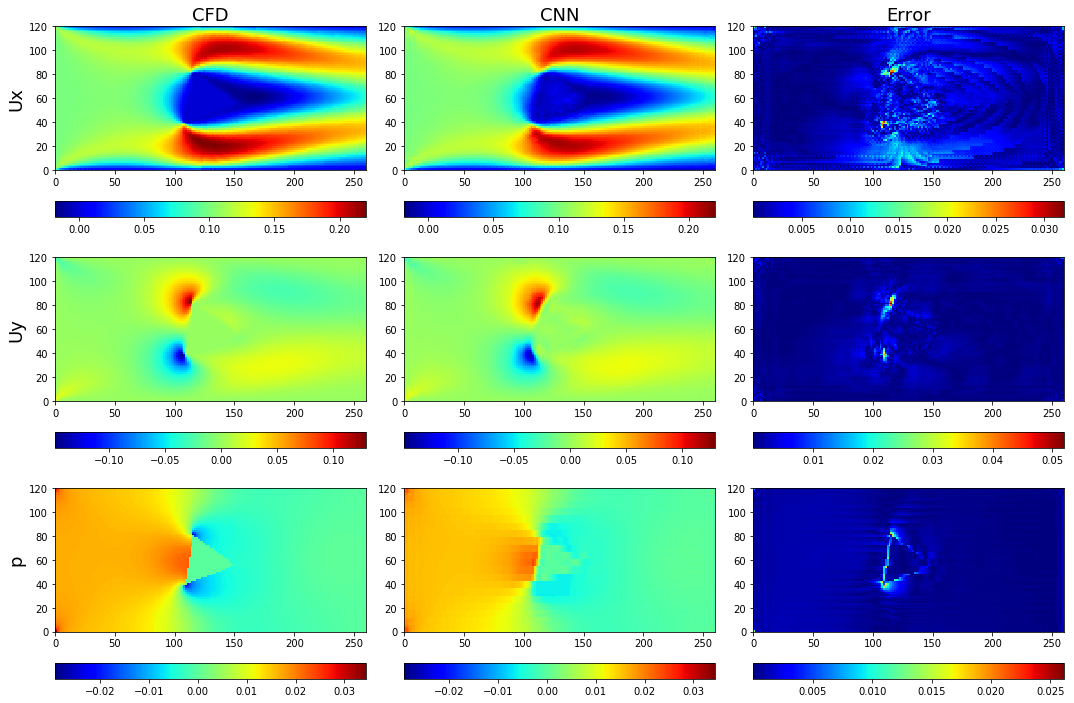

In [14]:
# 测试训练模型
out = net(test_x)
# 计算残差
error = paddle.abs(out.cpu() - test_y.cpu())
# 作出CFD和CNN的计算结果对比图以及对应的残差图(s可修改)
s = 0
visualize(test_y.detach().numpy(), out.detach().numpy(), error.detach().numpy(), s)

In [13]:
# 指标符合性分析
# Total MSE
Total_MSE = paddle.sum((out-test_y)**2)/len(test_x)
# Ux MSE
Ux_MSE = paddle.sum((out[:,0,:,:]-test_y[:,0,:,:])**2)/len(test_x)
# Uy MSE
Uy_MSE = paddle.sum((out[:,1,:,:]-test_y[:,1,:,:])**2)/len(test_x)
# p MSE
p_MSE = paddle.sum((out[:,2,:,:]-test_y[:,2,:,:])**2)/len(test_x)
print("Total MSE is {}, Ux MSE is {}, Uy MSE is {}, p MSE is {}".format(Total_MSE.detach().numpy()[0], Ux_MSE.detach().numpy()[0], Uy_MSE.detach().numpy()[0], p_MSE.detach().numpy()[0]))

Total MSE is 1.8955801725387573, Ux MSE is 0.6953578591346741, Uy MSE is 0.21001338958740234, p MSE is 0.9902092218399048
